In [1]:
import pandas as pd

# 指定第一行作为列名
his = pd.read_csv("/content/drive/MyDrive/0050.csv", header=1)  #從第二列開始提取
his = his.drop(columns=["成交金額","除權值","Unnamed: 8"]) #刪除不必要欄位
his['日期'] = pd.to_datetime(his['日期'], format='%Y%m%d') #修改日期格式
his.set_index("日期", inplace=True)
his = his[:-1] #載入資料最新日期還正在開盤，可能不準確，所以刪除
#刪除過於久遠的資料
start_date = pd.to_datetime('2013-01-01')
his = his[his.index >= start_date]

In [2]:
his

開盤價     最高價     最低價     收盤價    成交量
日期                                               
2013-01-02   54.00   54.65   53.90   54.40  16487
2013-01-03   54.90   55.05   54.65   54.85  29020
2013-01-04   54.85   54.85   54.40   54.50   9837
2013-01-07   54.55   54.55   53.90   54.25   8910
2013-01-08   54.00   54.20   53.65   53.90  12507
...            ...     ...     ...     ...    ...
2023-09-25  122.75  123.75  122.75  123.55   4337
2023-09-26  122.65  123.00  122.00  122.10  11388
2023-09-27  121.85  122.30  121.55  122.15   7068
2023-09-28  122.75  123.15  122.05  122.65   5881
2023-10-02  123.60  124.50  123.60  124.25   6751

[2629 rows x 5 columns]

In [3]:
y_data = pd.DataFrame(his["收盤價"],columns=["收盤價"]) #先將收盤價單獨提取出來，稍後歸一化會使用
y_data

收盤價
日期                
2013-01-02   54.40
2013-01-03   54.85
2013-01-04   54.50
2013-01-07   54.25
2013-01-08   53.90
...            ...
2023-09-25  123.55
2023-09-26  122.10
2023-09-27  122.15
2023-09-28  122.65
2023-10-02  124.25

[2629 rows x 1 columns]

In [4]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler #歸一化
x_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()
scaled_x=pd.DataFrame(x_scaler.fit_transform(his),columns=his.columns)
scaled_y=pd.DataFrame(y_scaler.fit_transform(y_data),columns=["收盤價"])

In [5]:
import numpy as np
MOVING = 100 #提取100天資料
all_x, all_y = [],[]
for i in range(len(scaled_x) - MOVING):
    x = scaled_x[i:i+MOVING] #一百天的開高低收
    y = y_data[i+MOVING:i+MOVING+1]["收盤價"] #一百零一天的收盤價
    all_x.append(x)
    all_y.append(y)
all_x, all_y = np.array(all_x), np.array(all_y)

In [6]:
SPLIT = 0.8 #將資料切割為訓練集與測試集
train_split = round(len(all_x) * SPLIT)
train_x, train_y = all_x[:train_split], all_y[:train_split]
test_x, test_y = all_x[train_split:], all_y[train_split:]

In [7]:
train_x

array([[[0.00707786, 0.01162791, 0.00967906, 0.01414141, 0.23143692],
        [0.01617796, 0.0156724 , 0.01732043, 0.01868687, 0.4164477 ],
        [0.0156724 , 0.01365015, 0.01477331, 0.01515152, 0.13327035],
        ...,
        [0.04246714, 0.04246714, 0.03922567, 0.03989899, 0.1244575 ],
        [0.03185035, 0.03286148, 0.03362201, 0.03737374, 0.08457087],
        [0.03437816, 0.03336704, 0.03464086, 0.03636364, 0.05069233]],

       [[0.01617796, 0.0156724 , 0.01732043, 0.01868687, 0.4164477 ],
        [0.0156724 , 0.01365015, 0.01477331, 0.01515152, 0.13327035],
        [0.01263903, 0.01061678, 0.00967906, 0.01262626, 0.11958608],
        ...,
        [0.03185035, 0.03286148, 0.03362201, 0.03737374, 0.08457087],
        [0.03437816, 0.03336704, 0.03464086, 0.03636364, 0.05069233],
        [0.03286148, 0.03286148, 0.03464086, 0.03636364, 0.03911901]],

       [[0.0156724 , 0.01365015, 0.01477331, 0.01515152, 0.13327035],
        [0.01263903, 0.01061678, 0.00967906, 0.01262626, 0.1

In [8]:
train_y

array([[0.03636364],
       [0.02929293],
       [0.03080808],
       ...,
       [0.87373737],
       [0.88232323],
       [0.88888889]])

In [9]:
test_x.shape

(506, 100, 5)

In [10]:
test_y.shape

(506, 1)

In [11]:
#搭建模型，這邊挑選LSTM
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_x.shape[1], 5)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Flatten())
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32701 (127.74 KB)
Trainable params: 32701 (127.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(optimizer="adam", loss="mean_squared_error") #優化器及loss函數挑選

In [13]:
from IPython.terminal.interactiveshell import validate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath="model.hdf5", monitor="val_loss",
                                  save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]
train_history = model.fit(train_x, train_y,
                validation_split=0.2,
                callbacks=callbacks,
                epochs=3000)

Epoch 1/3000
51/51 [==============================] - 14s 28ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 2/3000
13/51 [======>.......................] - ETA: 0s - loss: 2.1005e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 1s 11ms/step - loss: 2.0256e-04 - val_loss: 0.0040
Epoch 3/3000
51/51 [==============================] - 1s 11ms/step - loss: 1.8838e-04 - val_loss: 0.0032
Epoch 4/3000
51/51 [==============================] - 1s 12ms/step - loss: 1.8184e-04 - val_loss: 0.0015
Epoch 5/3000
51/51 [==============================] - 1s 11ms/step - loss: 1.7082e-04 - val_loss: 0.0019
Epoch 6/3000
51/51 [==============================] - 1s 12ms/step - loss: 1.6856e-04 - val_loss: 9.8142e-04
Epoch 7/3000
51/51 [==============================] - 1s 12ms/step - loss: 1.6681e-04 - val_loss: 9.2142e-04
Epoch 8/3000
51/51 [==============================] - 1s 11ms/step - loss: 1.5256e-04 - val_loss: 8.4151e-04
Epoch 9/3000
51/51 [==============================] - 1s 11ms/step - loss: 1.6181e-04 - val_loss: 7.9937e-04
Epoch 10/3000
51/51 [==============================] - 1s 11ms/step - loss: 1.4536e-04 - val_loss: 9.8016e-04
Epoch 11/3000
51/51 [==========================

In [14]:
preds = model.predict(test_x) #對測試資料進行預測
preds

16/16 [==============================] - 1s 7ms/step


array([[0.8681004 ],
       [0.8612251 ],
       [0.8769425 ],
       [0.88543093],
       [0.87892073],
       [0.8662535 ],
       [0.8623643 ],
       [0.88555986],
       [0.88328624],
       [0.8871373 ],
       [0.87320375],
       [0.8675539 ],
       [0.87120855],
       [0.82179725],
       [0.8500083 ],
       [0.8651007 ],
       [0.8676921 ],
       [0.8493533 ],
       [0.8084744 ],
       [0.8253146 ],
       [0.7969724 ],
       [0.7904038 ],
       [0.7741756 ],
       [0.79220235],
       [0.8155674 ],
       [0.8097757 ],
       [0.7834946 ],
       [0.7951729 ],
       [0.8010767 ],
       [0.83443236],
       [0.8337141 ],
       [0.83952135],
       [0.83563626],
       [0.8307411 ],
       [0.8291664 ],
       [0.8289263 ],
       [0.84411913],
       [0.8405823 ],
       [0.8409163 ],
       [0.8280928 ],
       [0.83692414],
       [0.8392801 ],
       [0.83951813],
       [0.84030724],
       [0.8521199 ],
       [0.8620937 ],
       [0.8800312 ],
       [0.869

In [15]:
preds = y_scaler.inverse_transform(preds) #將歸一化資料恢復原數值
preds

array([[138.94194 ],
       [138.26129 ],
       [139.8173  ],
       [140.65767 ],
       [140.01315 ],
       [138.7591  ],
       [138.37407 ],
       [140.67043 ],
       [140.44534 ],
       [140.8266  ],
       [139.44717 ],
       [138.88783 ],
       [139.24965 ],
       [134.35793 ],
       [137.15082 ],
       [138.64496 ],
       [138.90152 ],
       [137.08598 ],
       [133.03897 ],
       [134.70613 ],
       [131.90027 ],
       [131.24997 ],
       [129.64337 ],
       [131.42804 ],
       [133.74117 ],
       [133.1678  ],
       [130.56596 ],
       [131.72212 ],
       [132.3066  ],
       [135.60881 ],
       [135.5377  ],
       [136.11261 ],
       [135.728   ],
       [135.24336 ],
       [135.08748 ],
       [135.0637  ],
       [136.5678  ],
       [136.21764 ],
       [136.25072 ],
       [134.98119 ],
       [135.85548 ],
       [136.08873 ],
       [136.11229 ],
       [136.19041 ],
       [137.35988 ],
       [138.34727 ],
       [140.1231  ],
       [139.1

In [16]:
MOVING

100

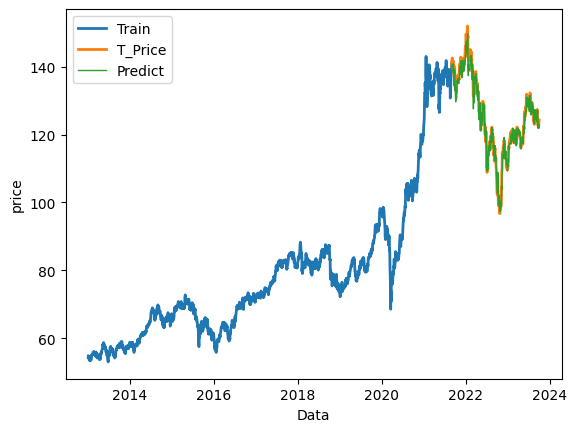

In [17]:
import matplotlib.pyplot as plt
train_df = his[:train_split+MOVING]
test_df = his[train_split+MOVING:]
test_df = test_df.assign(Predict = preds)

plt.xlabel("Data")
plt.ylabel("price")
plt.plot(train_df["收盤價"], linewidth=2)
plt.plot(test_df["收盤價"], linewidth=2)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "T_Price", "Predict"])
plt.show()

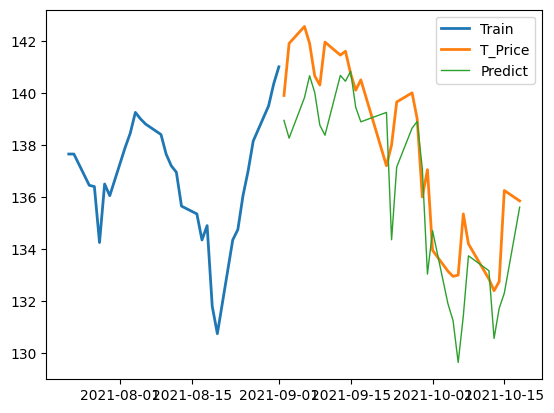

In [18]:
plt.plot(train_df["收盤價"][-30:], linewidth=2)
plt.plot(test_df["收盤價"][:30], linewidth=2)
plt.plot(test_df["Predict"][:30], linewidth=1)
plt.legend(["Train", "T_Price", "Predict"])
plt.show()

In [19]:
train_df[["收盤價"]]

收盤價
日期                
2013-01-02   54.40
2013-01-03   54.85
2013-01-04   54.50
2013-01-07   54.25
2013-01-08   53.90
...            ...
2021-08-26  137.00
2021-08-27  138.15
2021-08-30  139.50
2021-08-31  140.35
2021-09-01  141.00

[2123 rows x 1 columns]

In [20]:
test_df[["收盤價","Predict"]]

收盤價     Predict
日期                            
2021-09-02  139.90  138.941940
2021-09-03  141.90  138.261292
2021-09-06  142.55  139.817307
2021-09-07  141.90  140.657669
2021-09-08  140.65  140.013153
...            ...         ...
2023-09-25  123.55  121.840118
2023-09-26  122.10  123.355881
2023-09-27  122.15  122.145004
2023-09-28  122.65  121.816971
2023-10-02  124.25  122.849449

[506 rows x 2 columns]

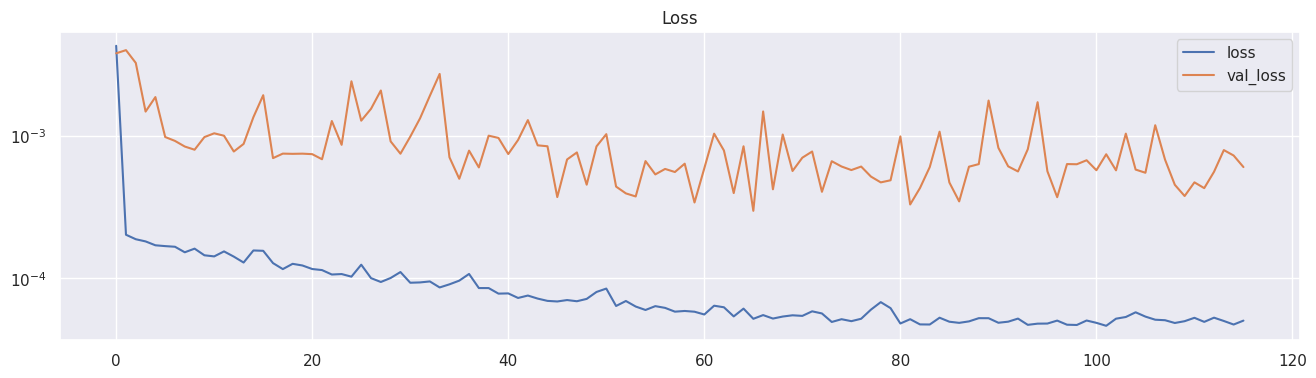

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#plt.style.use("seaborn-v0_8")
fig, ax=plt.subplots(figsize=(16,4))
ax.set_title("Loss")
ax.set_yscale("log")
ax.plot(train_history.history["loss"], label="loss")
ax.plot(train_history.history["val_loss"], label="val_loss")
ax.legend()

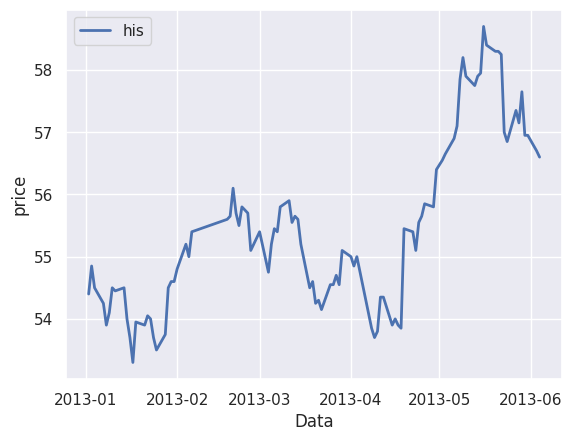

In [22]:
import matplotlib.pyplot as plt
train_df = his[:100]


plt.xlabel("Data")
plt.ylabel("price")
plt.plot(train_df["收盤價"], linewidth=2)

plt.legend(["his"])
plt.show()